In [10]:
%matplotlib inline
import module,math,random
import sys,matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA as sklearnPCA
import matplotlib
from pathwayGenes import *
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rc('font', family='sans-serif')
matplotlib.rc('font', serif='Arial')
matplotlib.rc('text', usetex='false')
matplotlib.rc('pdf', fonttype=42)
fig_base = '/home/james/Dropbox/Miller/figures/'

In [6]:
class kallisto_parser:
    
    results_folder = 'kalisto_results_collapsed'
    results_file = 'All_RNA_samples.tsv'
    
    ##list of all samples in order
    sample_list = []
    
    ##stores conditions for each sample
    sample_table = {}
    
    ##batch of each sample
    sample_batch = {}
    
    ##names of genes in gene_exp_matrix
    gene_name_list = []
    ensid_list = []
    ##array of gene expression
    gene_exp_matrix = []
    
    
    ##stores gene expression in a dictionary
    result_dict = {}
    
    
    MIN_MEAN_EXP = 3

    ##returns a set of ensids to be masked
    def load_GTF_mask(self,maskfile):
        f = open(maskfile)
        
        mask_set = set()
        print ;
        for line in f:
            split = line.strip().split('\t')
            atribs = split[-1]
            cur_gene_id = atribs.split('"')[1]
            mask_set.add(cur_gene_id)
            
        return mask_set
    
    ##loads a single results, stores it in result_dict (all files have same ## of genes)
    def load_kal_result(self,infile):


        f = open(infile,'r')
        f.readline()

        for line in f:
            line = line.strip()
            split = line.split('\t')
            cur_ensid = split[0]
            cur_tpm = float(split[-1])

            if cur_ensid not in self.result_dict:
                self.result_dict[cur_ensid] = []
            self.result_dict[cur_ensid].append(cur_tpm)
            
    def load_sample_results(self):
        
        for cur_sample in self.sample_list:
            cur_sample_path = self.results_folder + '/' + cur_sample + '/abundance.tsv'
            self.load_kal_result(cur_sample_path)
    
    ##makes and normalizes a gene expression table
    def make_result_table(self,mask_file='',SCALE=False,NORM=True,CENTER=False,NAMES=True):
        
        snames = module.ENSidDict()
        result_table_list = []
        gene_name_list = []
        
        tomask = set()
        if mask_file:
            tomask = self.load_GTF_mask(mask_file)
        
        for ensid in self.result_dict.keys():
            
            cur_exp = np.array(self.result_dict[ensid])
            
            if np.mean(cur_exp) < self.MIN_MEAN_EXP:
                #print 'low'
                continue
                
            if ensid in tomask:
                continue
            
            cur_name = ensid
            if NAMES:
                cur_name = snames[ensid]
                
            if SCALE:
                cur_exp = cur_exp/np.sum(cur_exp)
            if CENTER:
                cur_exp = cur_exp - cur_exp.mean()
                
            self.gene_name_list.append(cur_name)
            self.ensid_list.append(ensid)
            result_table_list.append(cur_exp)
            
        self.gene_exp_matrix = np.array(result_table_list) 
        if NORM:
            mean_exp =  np.mean(self.gene_exp_matrix,axis=0)
            #print mean_exp
            scaler = mean_exp/np.mean(mean_exp)
            self.gene_exp_matrix = self.gene_exp_matrix/scaler
        print "Created a GEM with %s genes" % len(self.gene_exp_matrix)
            
        
    ##loads results and conditions into a dictionary
    def load_results_key(self):
        f = open(self.results_file,'r')
        ##chomp
        f.readline()


        for line in f:
            line = line.strip()
            split = line.split('\t')
            name = split[0]
            condition = split[1]
            run = split[2]
            self.sample_table[name] = condition
            self.sample_batch[name] = run
            self.sample_list.append(name)
            
    def write_kal_table(self,outfile,NAMES=True):
        
        w = open(outfile,'w')
        
        header = ['gene_name']
        header = header + self.sample_list
        header_line = '\t'.join(header)
        w.write(header_line + '\n')
        
        if NAMES:
            for gene_name,gene_exp in zip(self.gene_name_list,self.gene_exp_matrix):
                gene_exp_list = list(gene_exp)
                gene_exp_list = map(lambda x: str(x),gene_exp_list)
                new_line_list = [gene_name] + gene_exp_list
                new_line = '\t'.join(new_line_list)
                w.write(new_line + '\n')
        else:
            for gene_name,gene_exp in zip(self.ensid_list,self.gene_exp_matrix):
                gene_exp_list = list(gene_exp)
                gene_exp_list = map(lambda x: str(x),gene_exp_list)
                new_line_list = [gene_name] + gene_exp_list
                new_line = '\t'.join(new_line_list)
                w.write(new_line + '\n')
        
        w.flush()
        w.close()
        
    ##makes all names unique
    def make_unique_names(self):
        cur_counts = {}
        new_list = []
        for gname in self.gene_name_list:
            
            if gname not in cur_counts:
                cur_counts[gname] = 0
                
            cur_counts[gname] += 1
            if cur_counts[gname] == 1:
                new_list.append(gname)
            else:
                gname = gname + '_' + str(cur_counts[gname])
                new_list.append(gname)
                
        self.gene_name_list = new_list
            
    def plot_gset_PCA(self):
        ##print exp_array.T.shape
        ##print exp_array.T
        print 'plotting PCA'
        rep_cov =  np.cov(self.gene_exp_matrix)
        eig_val, eig_vec = np.linalg.eig(rep_cov)
        obs = len(self.gene_exp_matrix)
        print 'plotting PCA'
        sklearn_pca = sklearnPCA(n_components=40)
        sklearn_transformed = sklearn_pca.fit_transform(self.gene_exp_matrix.T)
        sklearn_pca.fit(self.gene_exp_matrix.T)
        print 'plotting PCA'
        ##print sklearn_pca.explained_variance_ratio_
        pc1 =  sklearn_pca.components_[0]
        ##print np.corrcoef(exp_array.T,y=pc1)
        print self.gene_exp_matrix[0] - self.gene_exp_matrix[0].mean()
        print np.corrcoef(sklearn_transformed[:,0],self.gene_exp_matrix[0]- self.gene_exp_matrix[0].mean())
        plt.figure()
        ##print sklearn_transformed
        plt.scatter(sklearn_transformed[:,0],sklearn_transformed[:,1],color='b')
        #plt.scatter(sklearn_transformed[6:12,0],sklearn_transformed[6:12,1],color='r')
        #return (sklearn_pca.explained_variance_ratio_,sklearn_pca.components_,sklearn_transformed)
        print sklearn_pca.explained_variance_ratio_
    
    ##fileters samples with conditions that matches the inName_list
    def filter_samples_by_names(self,inName_List):

        sample_list = np.array(self.sample_list)
        
        filtered =  np.array(map(lambda x: self.sample_table[x] not in inName_List,self.sample_list))

        filtered_exp_matrix = self.gene_exp_matrix[:,filtered]
        sample_list = sample_list[filtered]
        self.gene_exp_matrix = filtered_exp_matrix
        self.sample_list = list(sample_list)
       

collapsed_kallisto = kallisto_parser()
collapsed_kallisto.results_file = 'All_RNA_samples_WT.tsv'
collapsed_kallisto.load_results_key()
collapsed_kallisto.load_sample_results()
collapsed_kallisto.make_result_table(mask_file='/home/james/Dropbox/Miller/data/BED/ensGene_2k_mask.gtf',NORM=True)
collapsed_kallisto.make_unique_names()
#collapsed_kallisto.write_kal_table('kallisto_collapsed_all_genes.tsv')
#collapsed_kallisto.write_kal_table('kallisto_collapsed_all_ensid.tsv',NAMES=False)
#collapsed_kallisto.filter_samples_by_names(['PAXB_DMSO','PAXB_LDN','RABS_DMSO','RABS_LDN','PxR_F1','CxR_F1'])
#collapsed_kallisto.write_kal_table('kallisto_collapsed_filtered_genes.tsv')
#collapsed_kallisto.write_kal_table('kallisto_collapsed_filtered_ensid.tsv',NAMES=False)
#collapsed_kallisto.filter_samples_by_names(['PAXB_DMSO','PAXB_LDN','RABS_DMSO','RABS_LDN','PxR_F1','CxR_F1','PAXB_FTE_Mut','Bmp6_Homo','Bmp6_Het'])
#collapsed_kallisto.write_kal_table('kallisto_collapsed_WT_genes.tsv')
#collapsed_kallisto.write_kal_table('kallisto_collapsed_WT_ensid.tsv',NAMES=False)

collapsed_kallisto.filter_samples_by_names(['PAXB_DMSO','PAXB_LDN','RABS_DMSO','RABS_LDN','PxR_F1','CxR_F1','PAXB_FTE_Mut','PAXB_FTE_WT','Bmp6_Homo','Bmp6_Het','Bmp6_WT'])
collapsed_kallisto.write_kal_table('kallisto_collapsed_parental_genes.tsv')
collapsed_kallisto.write_kal_table('kallisto_collapsed_parental_ensid.tsv',NAMES=False)


Created a GEM with 14235 genes


In [3]:
def load_tc_epi_mes(tc_data_path='/home/james/Dropbox/Miller/data/BED/Regulatory_Evidence_Table_Dec_14_2011.tsv',STAGE=[],REG=[],CASE=''):
    
    epi_genes = {}
    mes_genes = {}
    total_genes = {}
    
    f = open(tc_data_path,'r')
    header = f.readline()
    for line in f:
        line = line.strip()
        split = line.split('\t')
        reg,target,test,effect,stage,reg_tissue,tissue = split[:7]
        target = target.upper()
        if CASE == 'lower':
            target = target.lower()
        if test == effect:
            direction = 1
        elif (test == '+' and effect == '-') or (test == '-' and effect == '+'):
            direction = -1
        else:
            direction = 0
        if REG and reg.upper() not in REG and reg[:-1].upper() not in REG:
            continue
        if STAGE and stage not in STAGE:
            continue
        total_genes[target] = direction
        if tissue == 'Epi':
            epi_genes[target] = direction
        if tissue == 'Mes':
            mes_genes[target] = direction
            
    for gene in mes_genes.keys()[:]:
        if gene in epi_genes:
            epi_genes.pop(gene)
            mes_genes.pop(gene)
        
    return epi_genes,mes_genes,total_genes
        
def load_TeTog(fpath='/home/james/Dropbox/James-Nick/LDN_RNA_seq/Gene Lists/TeTog_comb.csv'):
    
    ##dict of TC_dicts
    TeTog_gset = {}
    
    f = open(fpath,'r')
    for line in f:
        line=line.strip()
        split = line.split(',')
        if len(split) < 2:
            continue
        gname = split[0].strip().upper()
        tissue = split[1].strip()
        if not gname:
            continue
        if tissue not in TeTog_gset:
            TeTog_gset[tissue] = {}
        TeTog_gset[tissue][gname]=1
        
    return TeTog_gset

#loads a list of genes from a file, returns a set of gene names
def load_gset_from_file(infile,field=0,header=False):
    gset = set()
    
    f = open(infile,'r')
    if header:
        f.readline()
    for line in f:
        ##print line
        line = line.strip()
        split = line.split('\t')
        gset.add(split[field].upper())
        
    return list(gset)


##Converts a loaded list of human orthologues to stickleback names
##if a human gene has 2 names orthologues, adds both to the returned list
def convert_gset_to_snames(inlist,hfile='/home/james/Dropbox/Miller/data/BED/ENS_id_name_plusHuman.tsv'):
    
    ##build a dict, keys are hnames, values are lists of orthologues (often of length 1)
    
    snames = set()
    f= open(hfile,'r')
    f.readline()
    
    orthologues = {}
    for line in f:
        line = line.strip()
        split = line.split('\t')
        if len(split) != 3:
            continue
        hname = split[2].upper()
        if hname not in orthologues:
            orthologues[hname] = []
        sname = split[1]
        orthologues[hname].append(sname)
    
    for hgene in inlist:
        hgene = hgene.upper()
        if hgene not in orthologues:
            continue
        cur_orthos = orthologues[hgene]
        for sgene in cur_orthos:
            snames.add(sgene)
    snames = list(snames)
    return snames

TeToG = load_TeTog()

cteeth_epi_names = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/Fraser_2013_insitu_epithelial.l')
cteeth_mes_names = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/Fraser_2013_insitu_mesenchymal.l')
cteeth_all_names = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/Fraser_2013_insitu.l')
test_teeth_names = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/Fraser_2013_insitu_plus.l')
zteeth_names = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/zfin_cb5_tooth.l')
BC_snames = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/BITECODE.l')
HFSC_hnames = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/Kandyba_2012_st01_marray.tsv',field=2,header=True)
HFSC_snames = convert_gset_to_snames(HFSC_hnames)
BMP_hnames = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/ToothCode_Bmp.tsv',field=0,header=False)
BMP_snames = convert_gset_to_snames(BMP_hnames)
WNT_hnames = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/ToothCode_Wnt.tsv',field=0,header=False)
WNT_snames = convert_gset_to_snames(WNT_hnames)
TGFB_hnames = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/ToothCode_Tgfb.tsv',field=0,header=False)
TGFB_snames = convert_gset_to_snames(TGFB_hnames)
SHH_hnames = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/ToothCode_Shh.tsv',field=0,header=False)
SHH_snames = convert_gset_to_snames(SHH_hnames)
FGF_hnames = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/ToothCode_Fgf.tsv',field=0,header=False)
FGF_snames = convert_gset_to_snames(FGF_hnames)
EDA_hnames = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/ToothCode_Eda.tsv',field=0,header=False)
EDA_snames = convert_gset_to_snames(EDA_hnames)
NOTCH_hnames = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/ToothCode_Notch.tsv',field=0,header=False)
NOTCH_snames = convert_gset_to_snames(NOTCH_hnames)
BMP_epi_hnames = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/Tooth_code_bmp_epi.l',field=0,header=False)
BMP_epi_snames = convert_gset_to_snames(BMP_epi_hnames)
BMP_mes_hnames = load_gset_from_file('/home/james/Dropbox/Miller/data/BED/Tooth_code_bmp_mes.l',field=0,header=False)
BMP_mes_snames = convert_gset_to_snames(BMP_mes_hnames)
msx_ids = ['id1','id2a','id3','id4','msxa','msxb','msxd','msxe']
prashar_list = ['GJA1', 'postna', 'postnb','dnpep (2 of 2)', 'dnpep (1 of 2)','dpysl3', 'gpr97', 'klf10', 'lox', 'f3a', 'hey1 (1 of 2)','hey1 (2 of 2)', 'id3', 'lamb3', 'serpinf1', 'pltp',
        'ugp2a','ugp2b']

z_cteeth_all_names = set(zteeth_names).union(cteeth_all_names)

for n in cteeth_epi_names:
    print n
all_tetog_names = set(TeToG['both']).union(set(TeToG['epi'])).union(set(TeToG['mes']))
print all_tetog_names
for n in cteeth_mes_names:
    print n
temp = set(cteeth_epi_names).difference(cteeth_mes_names)
cteeth_mes_names = set(cteeth_mes_names).difference(cteeth_epi_names)
cteeth_epi_names = temp
w = open('/home/james/Dropbox/Miller/data/BED/TeToG_snames.l','w')
for gene in all_tetog_names:
    w.write(gene + '\n')
w.flush()
w.close()

BMP6
BMP4
NOTCH1B
NOTCH1A
SOSTDC1B
EDA
IRX1A
IRX1B
CTNNB1
SOX2
JAG2B
SHHA
PITX2
BMP2B
WNT5A
FGF3
set(['LHX8A', 'SCPP9', 'DPT', 'ACVR1L', 'SCPP1', 'SCPP5', 'CTNNB1', 'SOX2', 'SHHA', 'SPRY4', 'PITX2', 'DLX4B', 'EVE1', 'RUNX2B', 'BMP2B', 'AXIN2', 'LHX6', 'ATP2B1A', 'SOSTDC1B', 'CYP26B1', 'SPARC', 'DLX5A', 'IRX2A', 'DLX3B', 'FSTA', 'NOTCH1B', 'DKK1A', 'NOTCH1A', 'BARX1', 'OSR2', 'ITGB3B', 'EDA', 'COL1A1A', 'LEF1', 'FGF4', 'FGFR2', 'FGF3', 'BMP6', 'CX43', 'BMP4', 'ODAM', 'DLX2B', 'DLX2A', 'ITGAV', 'IRX1B', 'DLX4A', 'JAG2B', 'SPP1', 'EDAR', 'WNT10A', 'PTCH2', 'WNT5A', 'PTCH1', 'FGF10A', 'FGF10B'])
BMP6
BMP4
BMP2B
WNT10A
DLX2A
OSR2
PTCH1
PTCH2
RUNX2B
FGF3
FGF10A
FGF10B


2749
(2749, 18)
2749
FTC_1(0.064)
FTC_2(0.064)
PAXB_P_1(0.060)
FTC_0(0.059)
PAXB_P_2(0.058)
RABS_1(0.055)
RABS_0(0.055)
RABS_2(0.055)
PAXB_P_0(0.055)
CERC_0(0.054)
JAMA_0(0.054)
JAMA_1(0.053)
JAMA_2(0.053)
LITC_2(0.053)
LITC_1(0.053)
LITC_0(0.052)
CERC_2(0.052)
CERC_1(0.051)
197
(197, 18)
197
PAXB_P_1(0.073)
PAXB_P_0(0.060)
JAMA_0(0.060)
FTC_0(0.060)
JAMA_2(0.058)
JAMA_1(0.058)
FTC_1(0.057)
CERC_0(0.057)
FTC_2(0.056)
LITC_1(0.055)
LITC_2(0.054)
LITC_0(0.054)
CERC_1(0.052)
PAXB_P_2(0.050)
RABS_1(0.050)
CERC_2(0.050)
RABS_2(0.049)
RABS_0(0.047)


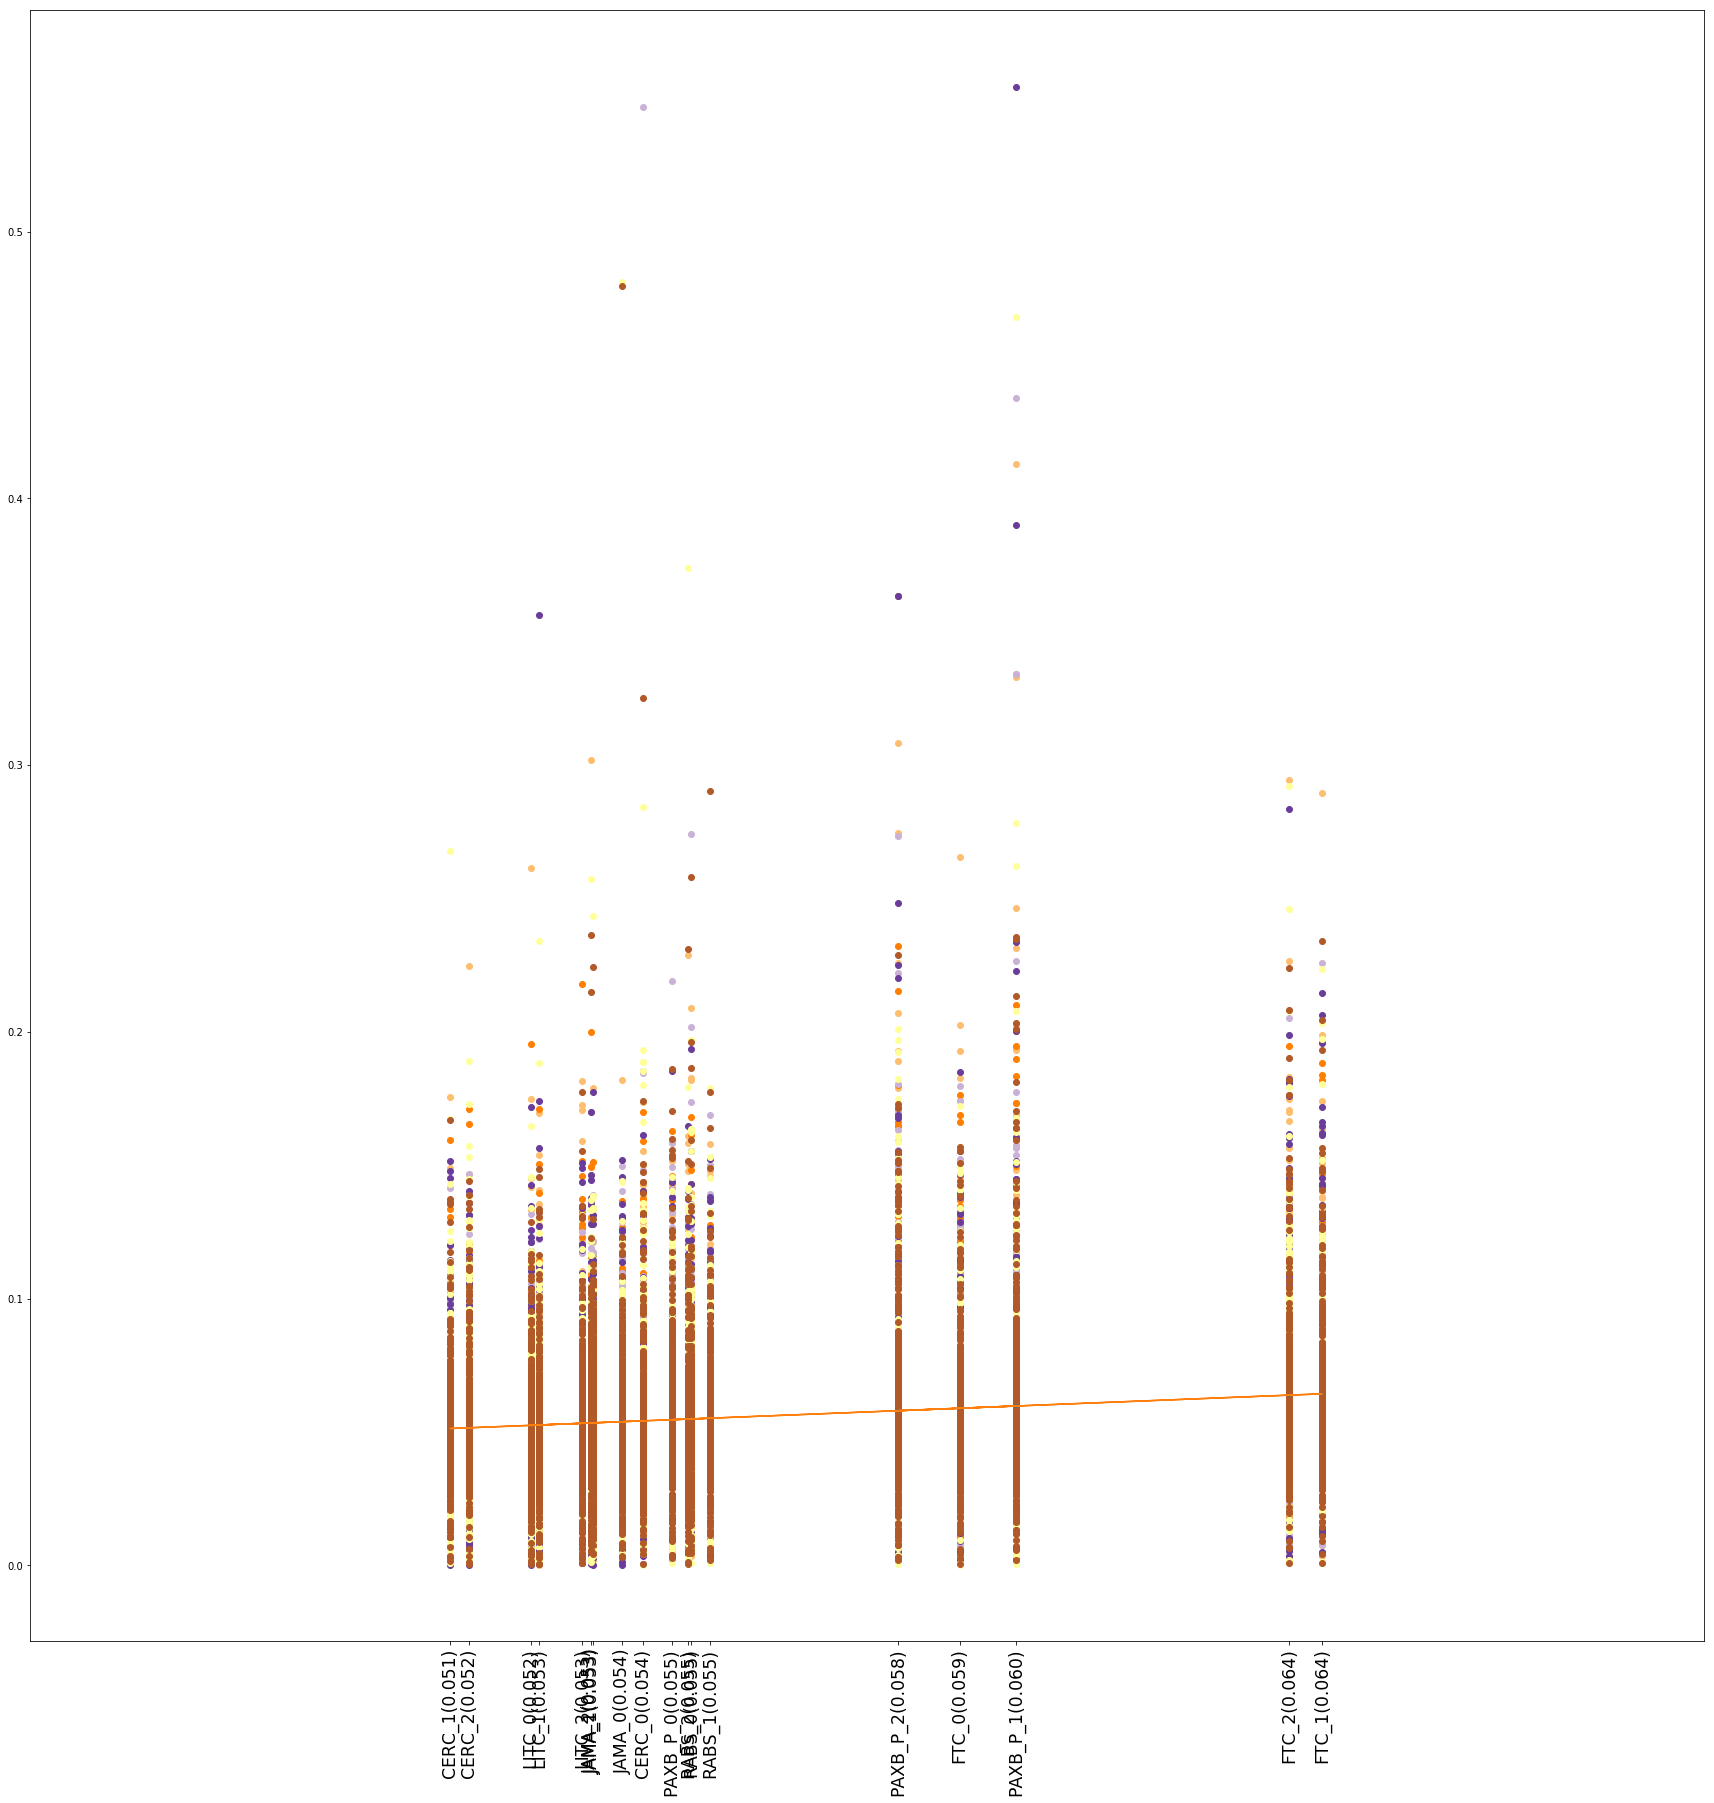

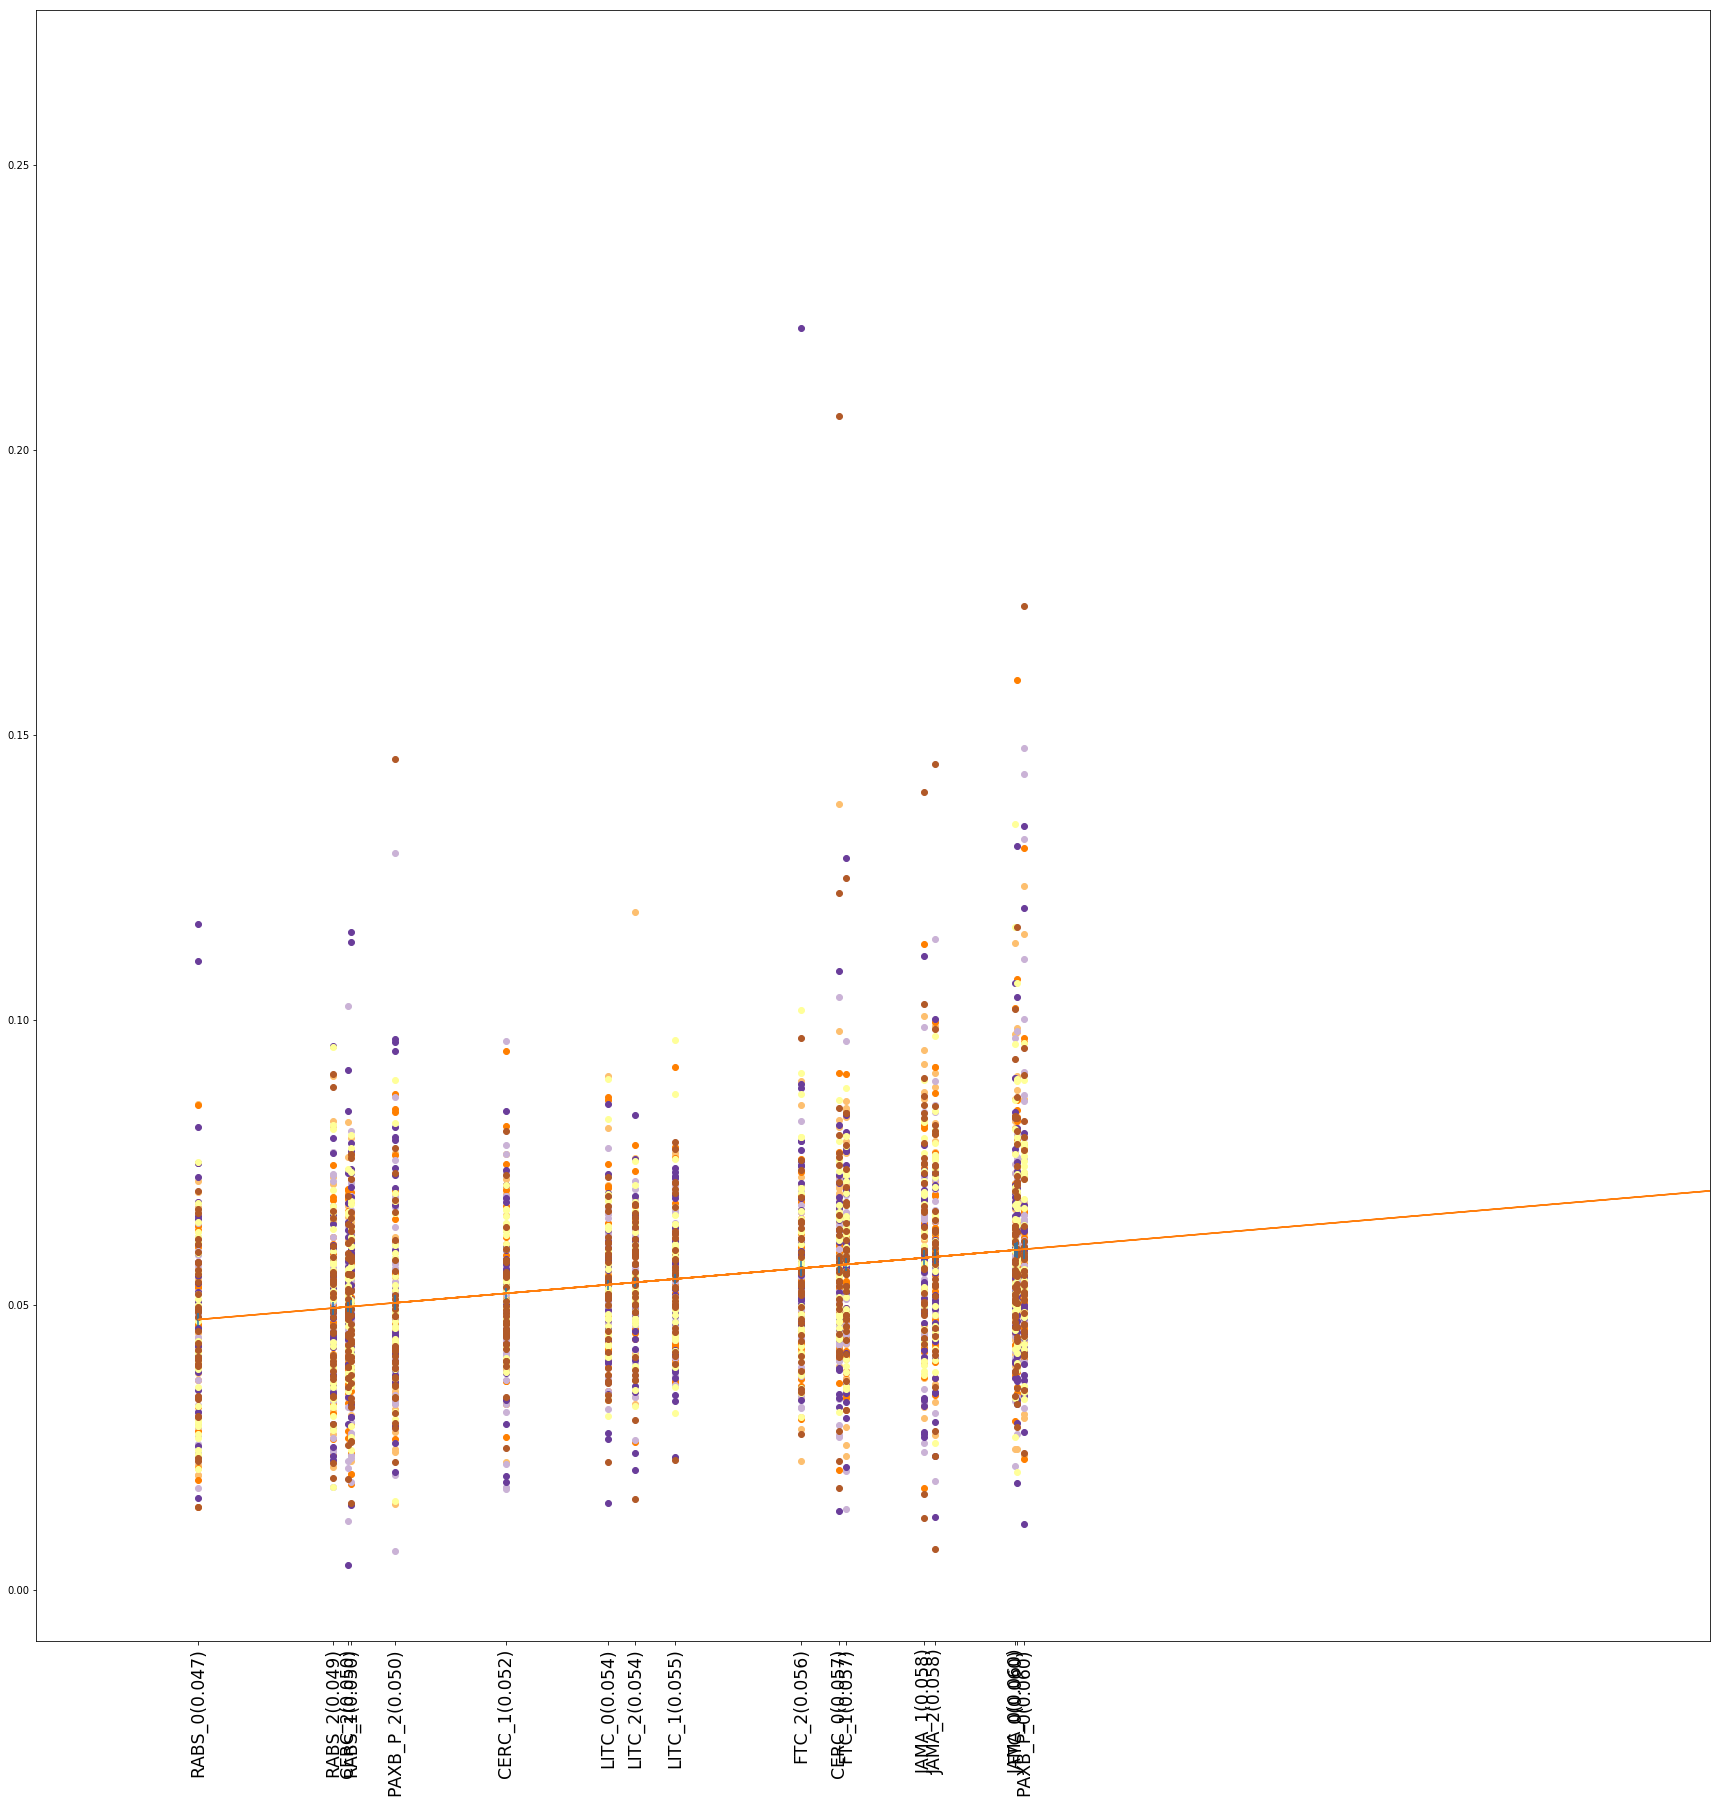

In [26]:
##loads expression from a tsv fpkm file
##returns a dict of expression keyed by gene name/id and a list of rep names
##each value is an array, not a list
def load_all_reps(infile,CENTER=False,SCALE=True,CUTOFF=.3):
    rep_names = []
    gene_exp = {}
    
    f = open(infile,'r')
    header = f.readline().strip().split('\t')
    rep_names = header[1:]
    for line in f:
        line = line.strip()
        split = line.split('\t')
        name = split[0]
        exp = map(lambda x:float(x),split[1:])
        exp = np.array(exp)
        if exp.min() < CUTOFF:
            continue
        if SCALE:
            exp = exp/exp.sum()
            ##exp = exp/exp.max()
        
        if CENTER:
            exp = exp-exp.mean()
        gene_exp[name]=exp
        if exp.min() < 0:
            print exp
    return rep_names,gene_exp

##gets a given gene set from the expression dict and returns it as an array
def get_gset(gene_exp,gset,LOOSE_NAMES=False,ORTHO=False):
    hnames = module.ENSid_Human_Dict()
    snames = module.ENSidDict()
    select_exp = []
    toret_gset = []
    for ensid in gene_exp.keys():
        if ORTHO:
            hortho = ''
            if ensid in hnames:
                hortho = hnames[ensid].upper()
                if hortho in gset:
                    select_exp.append(gene_exp[ensid])
                    toret_gset.append(snames[ensid])
        else:
            cur_sname = snames[ensid].split()[0].upper()
            if (cur_sname + 'A' in gset) and (cur_sname not in gset):
                cur_sname = cur_sname + 'A'
            if (cur_sname + 'B' in gset) and (cur_sname not in gset):
                cur_sname = cur_sname + 'B'
            if (cur_sname in gset):
                select_exp.append(gene_exp[ensid])
                toret_gset.append(snames[ensid])
    select_exp = np.array(select_exp)
    return select_exp,toret_gset

##takes an exp_array and plots it
def plot_gset(exp_array,rep_names,gene_names,c_scale='Paired',XLIM=[0,.2],BT_VTP = []):
    
    c_map = plt.get_cmap(c_scale)
    cur_color = .5
    
    
    
    plt.figure(figsize=(30,30))
    print len(exp_array)
    print exp_array.shape
    print len(exp_array.mean(axis=1))
    if not BT_VTP:
        xs = np.mean(exp_array,axis=0)
    else:
        xs = np.array(BT_VTP)
        xs = xs / np.sum(xs)
    rep_withMean = []
    for r,x in zip(rep_names,xs):
        rep_withMean.append(r + '(%.3f)' % x)
    ##xs = np.mean(exp_array,axis=0)
    rep_temp = np.array(rep_withMean)
    rep_temp = rep_temp[np.argsort(xs)][::-1]
    for i in rep_temp:
        print i
    pval_list = []
    for indI,i in enumerate(exp_array):
        cur_color += 1. / (2 * len(exp_array))
        plt.scatter(xs,i,color=c_map(cur_color))
        ##plt.plot(xs,i,color=c_map(cur_color))
        m,b, rval,pval,stderr = stats.linregress(xs,i)
        ##print gene_names[indI],i
        pval_list.append( (gene_names[indI],rval,pval))
    pval_list.sort(key=lambda x: -1*x[1])
    #for i in pval_list:
        #print i
    plt.errorbar(xs,np.mean(exp_array,axis=0),yerr=stats.sem(exp_array,axis=0),ls='')
    plt.xticks(xs,rep_withMean,rotation=90,fontsize='xx-large')
    
    plt.xlim(XLIM)
    m,b = np.polyfit(xs,np.mean(exp_array,axis=0),1)
    multi_xs = np.resize(xs,(len(exp_array),len(xs)))
    ##print np.size(multi_xs)
    ##print len(exp_array)
    #print stats.linregress(xs,np.mean(exp_array,axis=0))
    ##print np.size(exp_array)
    #print m,b
    #print stats.linregress(exp_array.flatten(),multi_xs.flatten())
    ##m,b = np.polyfit(exp_array.flatten(),multi_xs.flatten(),1)

    ##print stats.linregress(xs,np.median(exp_array,axis=0))
    ys = xs*m + b
    plt.plot(xs,ys)
    ##plt.ylim(XLIM)
    ##plt.xticks(xs,xs,rotation=90)
    
'''
all_names,all_exp = load_all_reps('kallisto_collapsed_filtered_ensid.tsv',SCALE=True,CENTER=False)

hfsc_array,hfsc_names = get_gset(all_exp,HFSC_hnames,ORTHO=True)
bmp_array,bmp_names = get_gset(all_exp,BMP_hnames,ORTHO=True)
wnt_array,wnt_names = get_gset(all_exp,WNT_hnames,ORTHO=True)
tgfb_array,tgfb_names = get_gset(all_exp,TGFB_hnames,ORTHO=True)
bc_array,bc_names = get_gset(all_exp,BC_snames,ORTHO=False) 
all_tetog_names = set(TeToG['both']).union(set(TeToG['epi'])).union(set(TeToG['mes']))
all_tetog_array,all_tetog_names = get_gset(all_exp,all_tetog_names) 
epi_tetog_array,epi_tetog_names = get_gset(all_exp,set(TeToG['epi'].keys())) 
mes_tetog_array,mes_tetog_names = get_gset(all_exp,set(TeToG['mes'].keys())) 

plot_gset(bc_array,all_names,bc_names,XLIM=[.015,.042])
'''

all_names,all_exp = load_all_reps('kallisto_collapsed_parental_ensid.tsv',SCALE=True,CENTER=False)
_,all_exp_names = load_all_reps('kallisto_collapsed_parental_genes.tsv',SCALE=True,CENTER=False)
total_exp,total_names = get_gset(all_exp,all_exp_names.keys(),ORTHO=False)
hfsc_array,hfsc_names = get_gset(all_exp,HFSC_hnames,ORTHO=True)
bc_array,bc_names = get_gset(all_exp,BC_snames,ORTHO=False) 
all_tetog_names = set(TeToG['both']).union(set(TeToG['epi'])).union(set(TeToG['mes']))
all_tetog_array,all_tetog_names = get_gset(all_exp,all_tetog_names) 
plot_gset(total_exp,all_names,total_names,XLIM=[.045,.07])

plot_gset(hfsc_array,all_names,hfsc_names,XLIM=[.045,.07])

In [27]:
##takes an exp_array and plots it
##returns a tuple of the type (cum_percent_var,componets,transformed)
def plot_gset_PCA(exp_array,rep_names,gene_names,COLOR='b',SYM=''):
    ##print exp_array.T.shape
    ##print exp_array.T
    rep_cov =  np.cov(exp_array)
    eig_val, eig_vec = np.linalg.eig(rep_cov)
    obs = len(exp_array)
    sklearn_pca = sklearnPCA(n_components=4)
    print exp_array.shape
    sklearn_transformed = sklearn_pca.fit_transform(exp_array.T)
    sklearn_pca.fit(exp_array.T)
    ##print sklearn_pca.explained_variance_ratio_
    pc1 =  sklearn_pca.components_[0]
    ##print np.corrcoef(exp_array.T,y=pc1)
    #print exp_array[0] - exp_array[0].mean()
    #print np.corrcoef(sklearn_transformed[:,0],exp_array[0]- exp_array[0].mean())
    plt.figure(figsize=(12,12))
    ##print sklearn_transformed
    if SYM:
        for (x,y,c,m) in zip(sklearn_transformed[:,0],sklearn_transformed[:,1],COLOR,SYM):
            plt.scatter(x,y,marker=m,c=c,s=70)
    else:
        plt.scatter(sklearn_transformed[:,0],sklearn_transformed[:,1],color=COLOR)
    #plt.scatter(sklearn_transformed[6:12,0],sklearn_transformed[6:12,1],color='r')
    return (sklearn_pca.explained_variance_ratio_,sklearn_pca.components_,sklearn_transformed)
    


(338, 18)
[ 0.37756773  0.18287979  0.11758343  0.07979467]
(197, 18)
[ 0.41749207  0.18629247  0.09313615  0.08859047]


'\na,b,c=plot_gset_PCA(all_tetog_array,samples_names,all_tetog_names,COLOR=sample_color,SYM=sample_sym)\nprint a\na,b,c=plot_gset_PCA(epi_tetog_array,samples_names,epi_tetog_names,COLOR=sample_color,SYM=sample_sym)\nprint a\na,b,c=plot_gset_PCA(mes_tetog_array,samples_names,mes_tetog_names,COLOR=sample_color,SYM=sample_sym)\nprint a\na,b,c=plot_gset_PCA(hfsc_array,samples_names,hfsc_names,COLOR=sample_color)\nprint a\na,b,c=plot_gset_PCA(bmp_array,samples_names,bmp_names,COLOR=sample_color)\nprint a\na,b,c=plot_gset_PCA(tgfb_array,samples_names,tgfb_names,COLOR=sample_color)\nprint a\na,b,c=plot_gset_PCA(wnt_array,samples_names,wnt_names,COLOR=sample_color)\nprint a\n'

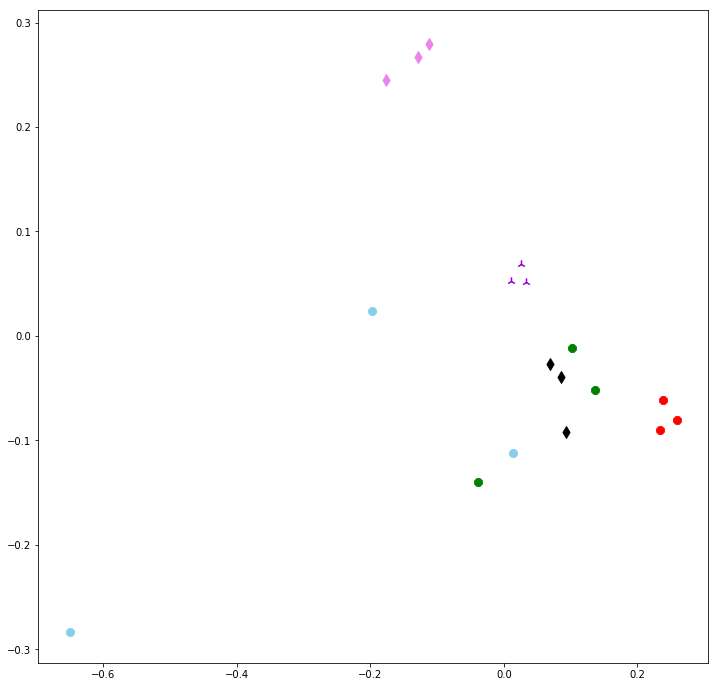

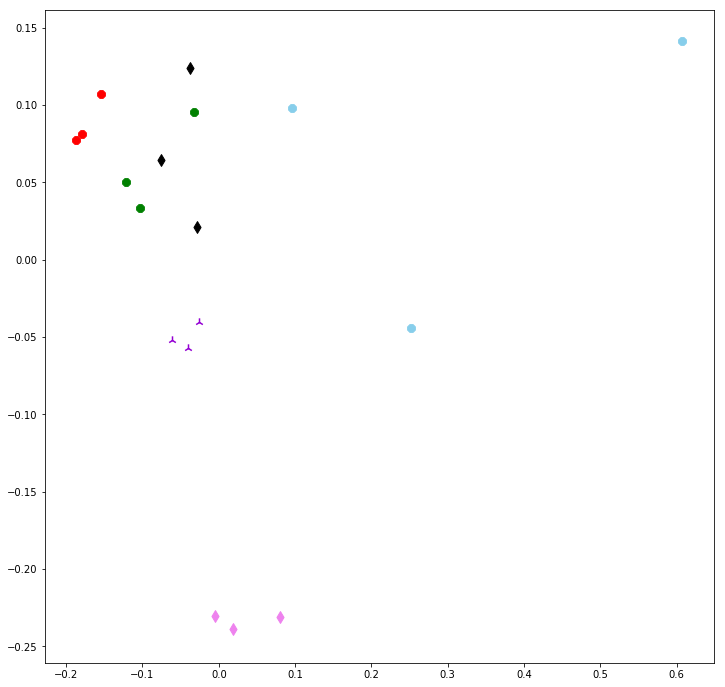

In [28]:
sample_names = collapsed_kallisto.sample_list

sample_type = map(lambda x: collapsed_kallisto.sample_table[x],sample_names)

type_color = {
    'CERC_WT' : 'green',
    'RABS_WT' : 'red',
    'PAXB_WT' : 'skyblue',
    'FTC_WT' : 'black',
    'PAXB_FTE_WT' : 'skyblue',
    'PAXB_FTE_Mut' : 'darkblue',
    'JAMA_WT' : 'violet',
    'Bmp6_Homo' : 'orange',
    'Bmp6_Het'  : 'goldenrod',
    'LITC_WT' : 'darkviolet'
}

type_run = {
    'JCH003' : u'3',
    'JCH004' : u'x',
    'JCH005' : u'8',
    'JCH006' : u'2',
    'JCH008' : u'h',
    'JCH010' : u'd',
    
    
    
}

sample_color = map(lambda x: type_color[collapsed_kallisto.sample_table[x]],sample_names)
sample_sym = map(lambda x: type_run[collapsed_kallisto.sample_batch[x]],sample_names)
all_names,all_exp = load_all_reps('kallisto_collapsed_parental_ensid.tsv',SCALE=True,CENTER=False)
all_tetog_names = set(TeToG['both']).union(set(TeToG['epi'])).union(set(TeToG['mes']))

all_tetog_array,all_tetog_names = get_gset(all_exp,all_tetog_names) 
epi_tetog_array,epi_tetog_names = get_gset(all_exp,set(TeToG['epi'].keys())) 
mes_tetog_array,mes_tetog_names = get_gset(all_exp,set(TeToG['mes'].keys())) 
hfsc_array,hfsc_names = get_gset(all_exp,HFSC_hnames,ORTHO=True)
bmp_array,bmp_names = get_gset(all_exp,BMP_hnames,ORTHO=True)
wnt_array,wnt_names = get_gset(all_exp,WNT_hnames,ORTHO=True)
tgfb_array,tgfb_names = get_gset(all_exp,TGFB_hnames,ORTHO=True)
bc_array,bc_names = get_gset(all_exp,BC_snames,ORTHO=False) 
hfsc_array,hfsc_names = get_gset(all_exp,HFSC_hnames,ORTHO=True)

a,b,c=plot_gset_PCA(bc_array,sample_names,bc_names,COLOR=sample_color,SYM=sample_sym)
print a
a,b,c=plot_gset_PCA(hfsc_array,sample_names,hfsc_names,COLOR=sample_color,SYM=sample_sym)
print a
'''
a,b,c=plot_gset_PCA(all_tetog_array,samples_names,all_tetog_names,COLOR=sample_color,SYM=sample_sym)
print a
a,b,c=plot_gset_PCA(epi_tetog_array,samples_names,epi_tetog_names,COLOR=sample_color,SYM=sample_sym)
print a
a,b,c=plot_gset_PCA(mes_tetog_array,samples_names,mes_tetog_names,COLOR=sample_color,SYM=sample_sym)
print a
a,b,c=plot_gset_PCA(hfsc_array,samples_names,hfsc_names,COLOR=sample_color)
print a
a,b,c=plot_gset_PCA(bmp_array,samples_names,bmp_names,COLOR=sample_color)
print a
a,b,c=plot_gset_PCA(tgfb_array,samples_names,tgfb_names,COLOR=sample_color)
print a
a,b,c=plot_gset_PCA(wnt_array,samples_names,wnt_names,COLOR=sample_color)
print a
'''

CERC_0      4.061942
CERC_1      3.035492
CERC_2      2.957412
RABS_0      1.309254
RABS_1      2.983690
RABS_2      1.992471
PAXB_P_0    2.664837
PAXB_P_1    5.361809
PAXB_P_2    2.381862
FTC_0       3.145362
FTC_1       3.372364
FTC_2       2.963292
JAMA_0      3.559589
JAMA_1      2.900982
JAMA_2      3.169019
LITC_0      3.349265
LITC_1      4.047192
LITC_2      2.538447
Name: bmp6, dtype: float64


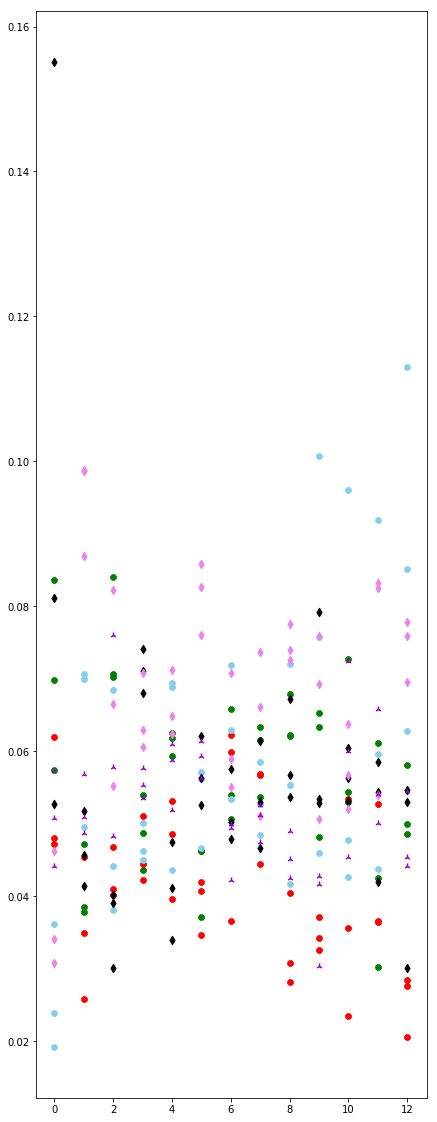

In [29]:
import pandas as pd
##plots a list of genes, and ignoring case matching generously

def plot_gene_list(gene_list,df):
    type_color = {
    'CERC_WT' : 'green',
    'RABS_WT' : 'red',
    'PAXB_WT' : 'skyblue',
    'FTC_WT' : 'black',
    'PAXB_FTE_WT' : 'darkblue',
    'PAXB_FTE_Mut' : 'darkblue',
    'JAMA_WT' : 'violet',
    'Bmp6_Homo' : 'orange',
    'Bmp6_Het'  : 'goldenrod',
    'LITC_WT' : 'darkviolet'
    }

    type_run = {
        'JCH003' : u'3',
        'JCH004' : u'x',
        'JCH005' : u'8',
        'JCH006' : u'2',
        'JCH008' : u'h',
        'JCH010' : u'd',



    }
    
    expanded_list = []
    for g in gene_list:
        for i in df.index:
            if g.upper() in i.upper():
                expanded_list.append(i)
                
    
      
    sample_names = list(df)
    sample_type = map(lambda x: collapsed_kallisto.sample_table[x],sample_names)
    sample_color = map(lambda x: type_color[collapsed_kallisto.sample_table[x]],sample_names)
    sample_sym = map(lambda x: type_run[collapsed_kallisto.sample_batch[x]],sample_names)
    for i,g in enumerate(expanded_list):
        exp = np.array(df[df.index == g])[0]

        norm_exp = exp / np.sum(exp)

        for (y,c,m) in zip(norm_exp,sample_color,sample_sym):
            plt.scatter(i,y,c=c,marker=m)
            
plt.figure(figsize=(7,20)) 
filtered_seq = pd.read_csv('kallisto_collapsed_parental_genes.tsv',sep='\t',header=0,index_col=0)
print filtered_seq.loc['bmp6']
#plot_gene_list(['bmp'],filtered_seq)
parental_seq = filtered_seq.loc[:,[not(('FTE' in x) or ('Bmp6' in x)) for x in list(filtered_seq)]]
plot_gene_list(['bmp'],parental_seq)

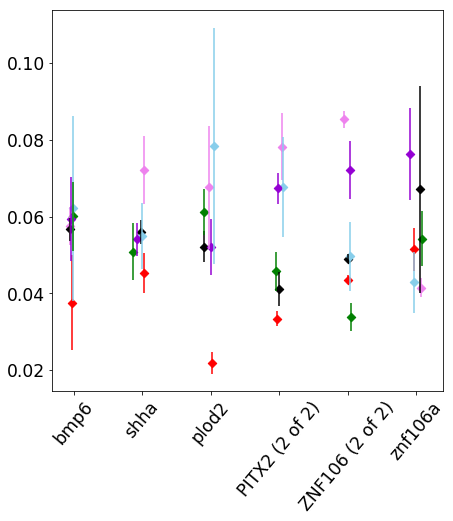

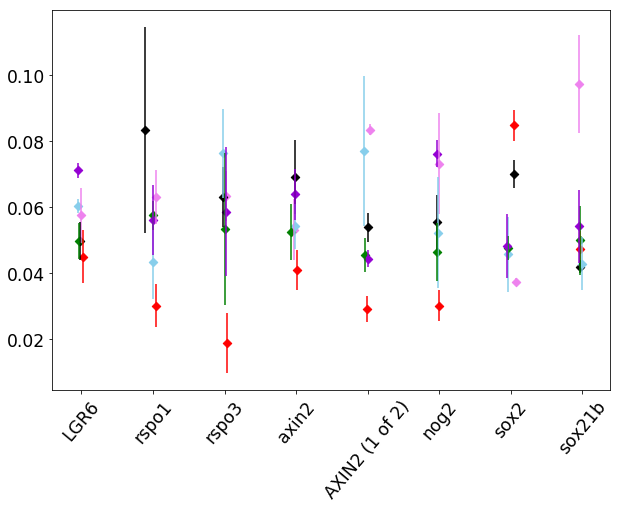

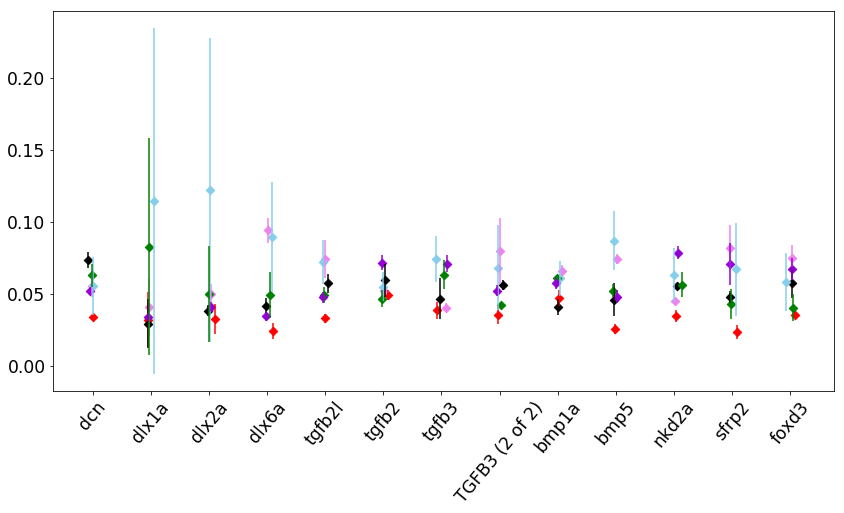

In [30]:



def plot_gene_list_mean(gene_list,df):
    type_color = {
    'CERC_WT' : 'green',
    'RABS_WT' : 'red',
    'PAXB_WT' : 'skyblue',
    'FTC_WT' : 'black',
    'PAXB_FTE_WT' : 'darkblue',
    'PAXB_FTE_Mut' : 'darkblue',
    'JAMA_WT' : 'violet',
    'Bmp6_Homo' : 'orange',
    'Bmp6_Het'  : 'goldenrod',
    'LITC_WT' : 'darkviolet'
    }

    type_run = {
        'JCH003' : u'3',
        'JCH004' : u'x',
        'JCH005' : u'8',
        'JCH006' : u'2',
        'JCH008' : u'h',
        'JCH010' : u'd',



    }
    
    expanded_list = []
    for g in gene_list:
        for i in df.index:
            if g.upper() in i.upper():
                expanded_list.append(i)
                
    
    
    
    
    for i,g in enumerate(expanded_list):
        exp = np.array(df[df.index == g])[0]

        norm_exp = exp / np.sum(exp)
        exp_by_sample = {}
        sample_names = list(df)
        sample_type = map(lambda x: collapsed_kallisto.sample_table[x],sample_names)
        #print norm_exp
        for name,cur_type,exp in zip(sample_names,sample_type,norm_exp):

            if cur_type not in exp_by_sample:
                exp_by_sample[cur_type] = []
            exp_by_sample[cur_type].append(exp)
        for x in exp_by_sample:
            toarray = np.array(exp_by_sample[x])
            exp_by_sample[x] = toarray
        pops = exp_by_sample.keys()
        #print pops

        sample_color = map(lambda x: type_color[x],exp_by_sample.keys())
        jitter = np.random.normal(loc=i,scale=.05,size=len(pops))
        for (pop,c,j) in zip(pops,sample_color,jitter):
            #print exp
            exp = exp_by_sample[pop]
            plt.scatter(j,exp.mean(),c=c,marker='D')
            plt.errorbar(j,exp.mean(),ecolor=c,yerr=exp.std())
        plt.xticks(range(0,len(expanded_list)),expanded_list,rotation=50,size='xx-large')
        plt.yticks(size='xx-large')

filtered_seq = pd.read_csv('kallisto_collapsed_parental_genes.tsv',sep='\t',header=0,index_col=0)

#plot_gene_list(['bmp'],filtered_seq)
parental_seq = filtered_seq.loc[:,[not(('FTE' in x) or ('Bmp6' in x)) for x in list(filtered_seq)]]
#print list(parental_seq)
plt.figure(figsize=(7,7))
plot_gene_list_mean(['bmp6','shha','plod2','pitx2','znf106'],parental_seq)  
plt.figure(figsize=(10,7))
plot_gene_list_mean(['lgr6','rspo1','rspo3','axin2','nog2','sox2'],parental_seq)
#parental_seq.loc['bmp6']
plt.figure(figsize=(14,7))
plot_gene_list_mean(['dcn','dlx1a','dlx2a','dlx6a','tgfb2','tgfb3','bmp1','bmp5','nkd2a','sfrp2','fsrp5','foxd3'],parental_seq)